# Introduction

The Local Ocean Conservation - Sea Turtle Face Detection on Zindi challenges participants to build an algorithm capable of drawing a bounding box around the all-important facial scales of a sea turtle. 

In this notebook we'll look at the data and build a very basic solution.

# Loading the data

I have the files in my Google Drive, which is mounted here in Colab. You can also upload the files directly.

In [13]:
from PIL import Image, ImageDraw
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# You can choose the 1024px version instead, but these are nice for initial testing
#!cp 'drive/My Drive/sea_turtles/IMAGES_512.zip' .
!unzip -q IMAGES_512.zip
image_folder = 'IMAGES_512'

/bin/bash: /home/alberto/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
replace IMAGES_512/974873B6.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
# Load train - edit path to suit your setup
train = pd.read_csv('./dataset/Train.csv')
print(train.shape)
train.head()

(1326, 5)


Image_ID         x         y         w         h
0  04FB1B33  0.481988  0.506076  0.174696  0.405671
1  B04E481E  0.617405  0.313368  0.177734  0.293113
2  32655645  0.490885  0.465856  0.165582  0.357350
3  44D4DA7C  0.472873  0.506076  0.237847  0.409722
4  4F36EF72  0.433811  0.574363  0.180773  0.397569

# View an Image

Let's check that we have the images where we expect them, and plot a bounding box to visualize our goal here:

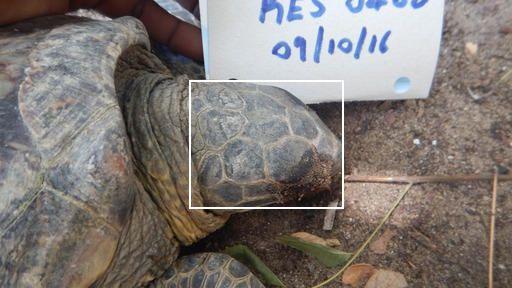

In [4]:
# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Open with PIL and draw a bounding box
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2)
im

## A Useful Library: Keras_Cv

Working with Computer Vision tasks (and object detection in particular) is quite hard.
For this reason, Keras has released a new library: keras_cv.

KerasCV's primary goal is to provide a coherent, elegant, and pleasant API to train state of the art computer vision models relying only on the tensorflow API.
assist in common computer vision tasks such as data-augmentation, classification, object detection, image generation, and more.
It allows to develop training and inference state-of-the art models and pipelines for tasks such as Augmentation, Object Detection, Image Segmentation and Image Classification.

We will use keras_cv for this task

Let us first install keras cv

In [3]:
!pip install git+https://github.com/keras-team/keras-cv

/bin/bash: /home/alberto/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/keras-team/keras-cv to /tmp/pip-req-build-z3cmxcex
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv /tmp/pip-req-build-z3cmxcex
  Resolved https://github.com/keras-team/keras-cv to commit a93f425a2e344dcc2231e7679c905be4dd8af098
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for keras-core from https://files.pythonhosted.org/packages/4e/53/58ffc04e861174034485d5cd4a9cdbb95f9788000ed7ca26c784be2a0d32/keras_core-0.1.0-py3-none-any.whl.metadata
  Using cached keras_core-0.1.0-py3-none-any.whl.metadata (3.9 kB)
  Obtaining dependency information for rich from https://files.pythonhosted.org/packages/fc/1e/482e5eec0b89b593e81d78f819a9412849814e22225842b598908e7ac560/rich-13.4.2-py

We now import the libraries we will need in the process

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_cv
import cv2
import numpy as np
from keras_cv import bounding_box
import pandas as pd

import resource
from keras_cv import visualization
import tqdm

Using TensorFlow backend


In [2]:
# Checking if the GPU is seen by the jupyter notebook (useful to check the correct installation of all the packages and the drivers for using tensorflow with the GPU).
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Definition of the hyperparameters of the model

In [3]:
# Size of the batch
BATCH_SIZE = 16
# Percentage of the training set to use as training set (the remainder will be used for the size of the validation set)
TRAIN_SPLIT = 0.8
# This value must be defined accordingly to the size that the learner takes in input. For many networks it's usually 224
INPUT_SIZE_LEARNER = 224

## Loading of the dataset

The first step is loading the dataset.
While this may seem a trivial step, when using a pretrained it is really important to be careful to the input desired by the pretrained model (on which kind of data it was trained).

In this case all the models have been pretrained on:
  - images with the 3 channels in the range [0, 255]
  - the location of the bounding boxes are in the range [0, IMG_WIDTH] and [0, IMG_HEIGHT]
  - the data will be a dictionary (useful for plotting later on the images, not required by the model)

In [4]:
def load_dataset(training=True):
    # define the base path to the input dataset and then use it to derive
    # the path to the images directory and annotation CSV file
    BASE_PATH = "dataset"
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "IMAGES_1024"])
    if training:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Train.csv"])
    else:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "SampleSubmission.csv"])

    # load the contents of the CSV annotations file
    print("[INFO] loading dataset...")
    rows = open(ANNOTS_PATH).read().strip().split("\n")
    # initialize the list of data (images), our target output predictions
    # (bounding box coordinates), along with the filenames of the
    # individual images
    data = []
    targets = []
    sizes = []

    # Remove the first row containing "ID, x, y, w, h"
    rows = rows[1:]

    for row in rows:
        # Split the fields of the .csv file
        row = row.split(',')
        filename = row[0]
        # Convert the coordinates from strings to floats
        coordinates = [float(v) for v in row[1:]]
        
        imagePath = os.path.sep.join([IMAGES_PATH, filename+'.JPG'])

        # Load the image of the desired size
        image = tf.keras.preprocessing.image.load_img(imagePath, target_size=(INPUT_SIZE_LEARNER, INPUT_SIZE_LEARNER))
        image = tf.keras.preprocessing.image.img_to_array(image)

        # If training get the coordinates, otherwise get the size for making the prediction as absolute values once you get the offset in range [0,1]
        if training:
            # scale the bounding box coordinates relative to the spatial
            # dimensions of the input image
            startX = coordinates[0] * INPUT_SIZE_LEARNER
            startY = coordinates[1] * INPUT_SIZE_LEARNER
            endX = (coordinates[0]+coordinates[2]) * INPUT_SIZE_LEARNER
            endY = (coordinates[1]+coordinates[3]) * INPUT_SIZE_LEARNER

            data.append(image)
            targets.append((startX, startY, endX, endY))
        else:
            # derive the path to the input image, load the image (in OpenCV
            # format), and grab its dimensions
            imagePath = os.path.sep.join([IMAGES_PATH, filename+'.JPG'])
            image = cv2.imread(imagePath)
            (img_h, img_w) = image.shape[:2]

            data.append(image)
            sizes.append((img_w, img_h))

    if training:
        dataset = tf.data.Dataset.from_tensor_slices((data, targets))
        dataset = dataset.map(lambda d,t: {'images':d, 'bounding_boxes': {'classes':tf.constant([0]), 'boxes':tf.reshape(t,[1,4])}})
    else:
        dataset = tf.data.Dataset.from_tensor_slices((data, sizes))
    
    print("[INFO] dataset loaded.")
    return dataset, len(data)

In [5]:
# Create the list with the names of the classes associated to the IDs used in the prediction.
# In our case we are predicting only turtles, so that will be the only element in this list
class_ids = ["Turtle"]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Let's now load the data and see if plotting the images results in what we are actually expecting or if we did some mistakes in the definition of the loading methods.

Furthermore, we divide our dataset into training and testing.

In [6]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs['images'], inputs['bounding_boxes']
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

# Load the dataset
dataset, data_size = load_dataset(training=True)

# Splitting the dataset into training and validation
train_size = int(data_size * TRAIN_SPLIT)
val_size = int(data_size * (1 - TRAIN_SPLIT))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)

[INFO] loading dataset...
[INFO] dataset loaded.


Let's batch now our data.
In object detection when using the Keras, it is recommended to use ragged batch of inputs. This is due to the fact that there may be different numbers of bounding boxes per image.

In [7]:
# Shuffle the training set
train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Finally, we can visualize the dataset.


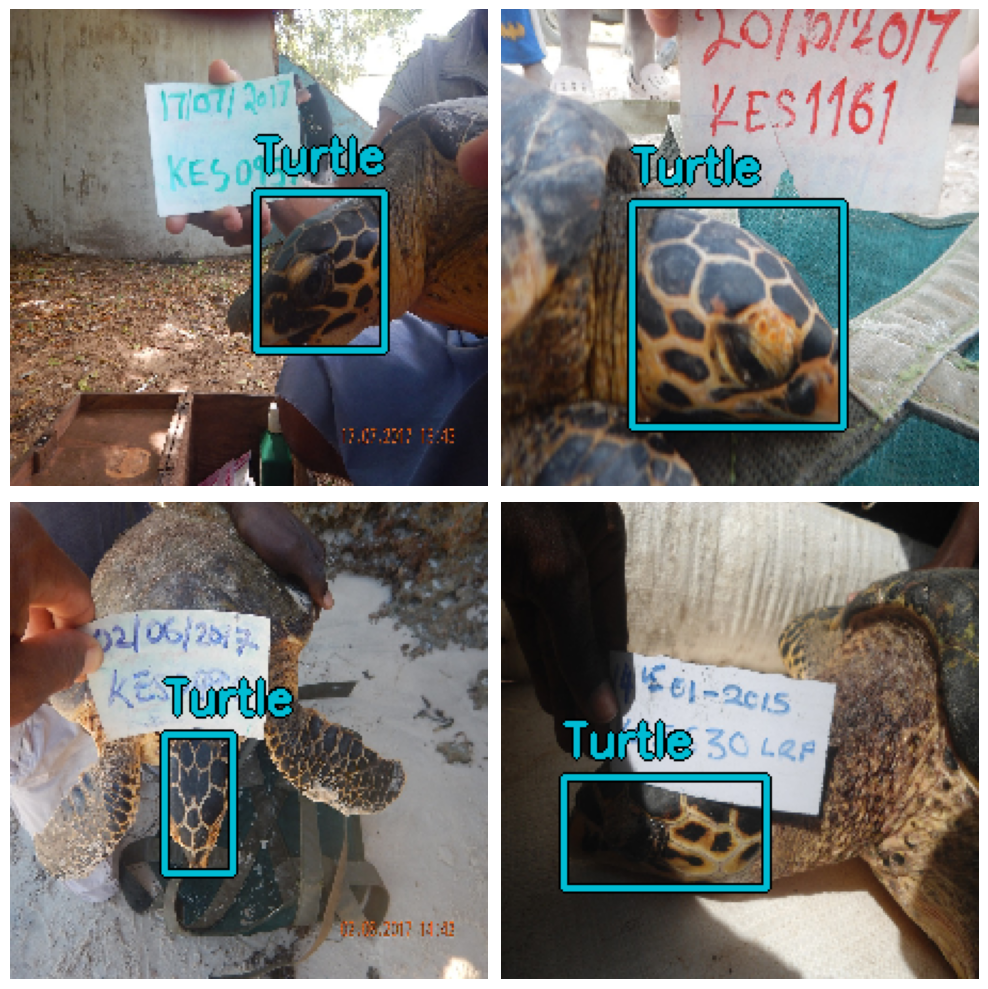

In [8]:
# Visualize the dataset by using the function we defined above.
# The training set
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

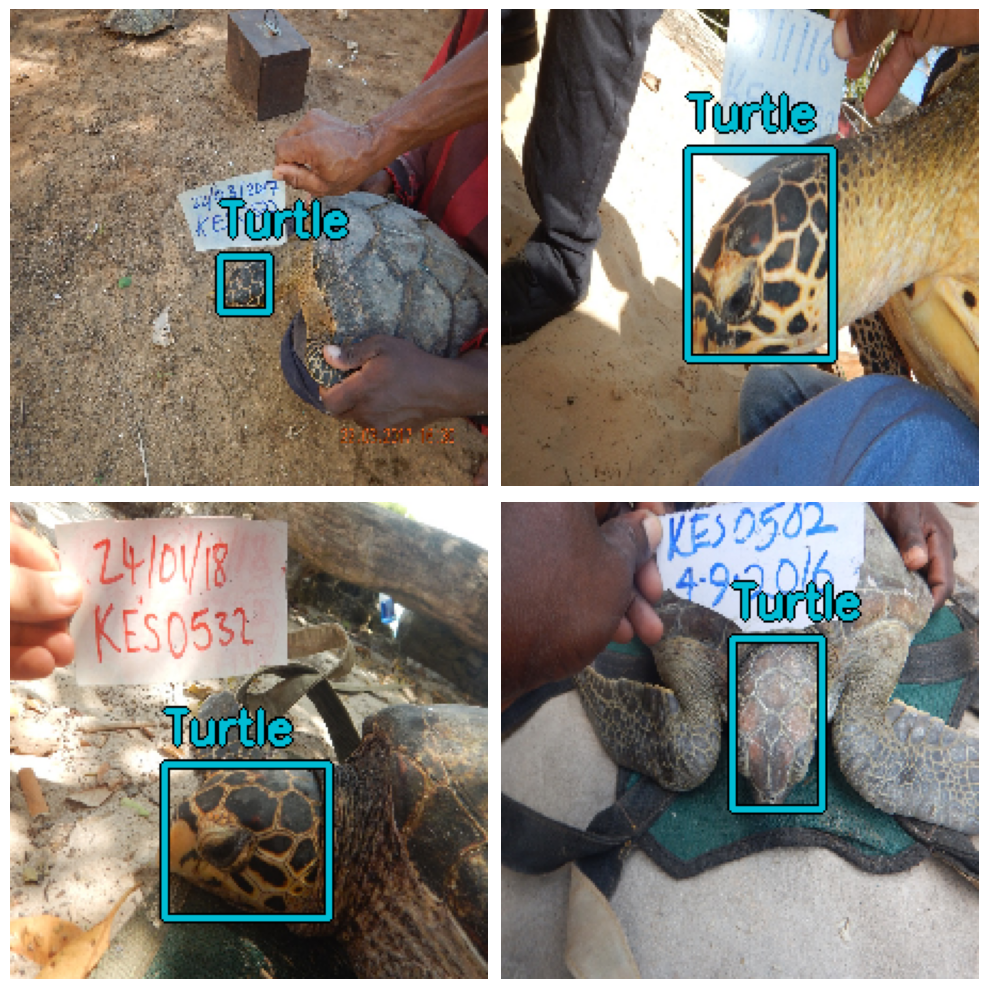

In [9]:
# And validation set
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

## Data Augmentation pipeline

Data Augmentation is the task of artificially generating samples in order to prevent the model from overfitting.
We want to modify the samples in such a way that the network instead of learning by heart the images, will try to understand the actual pattern and how the head of the turtle is done.

For image classification this is easy, while for object detection the task can be quite tedious as the modification of the image implies also the modification of the coordinates of the bounding box.
With keras_cv augmentation is made easier and is handled by the library itself.

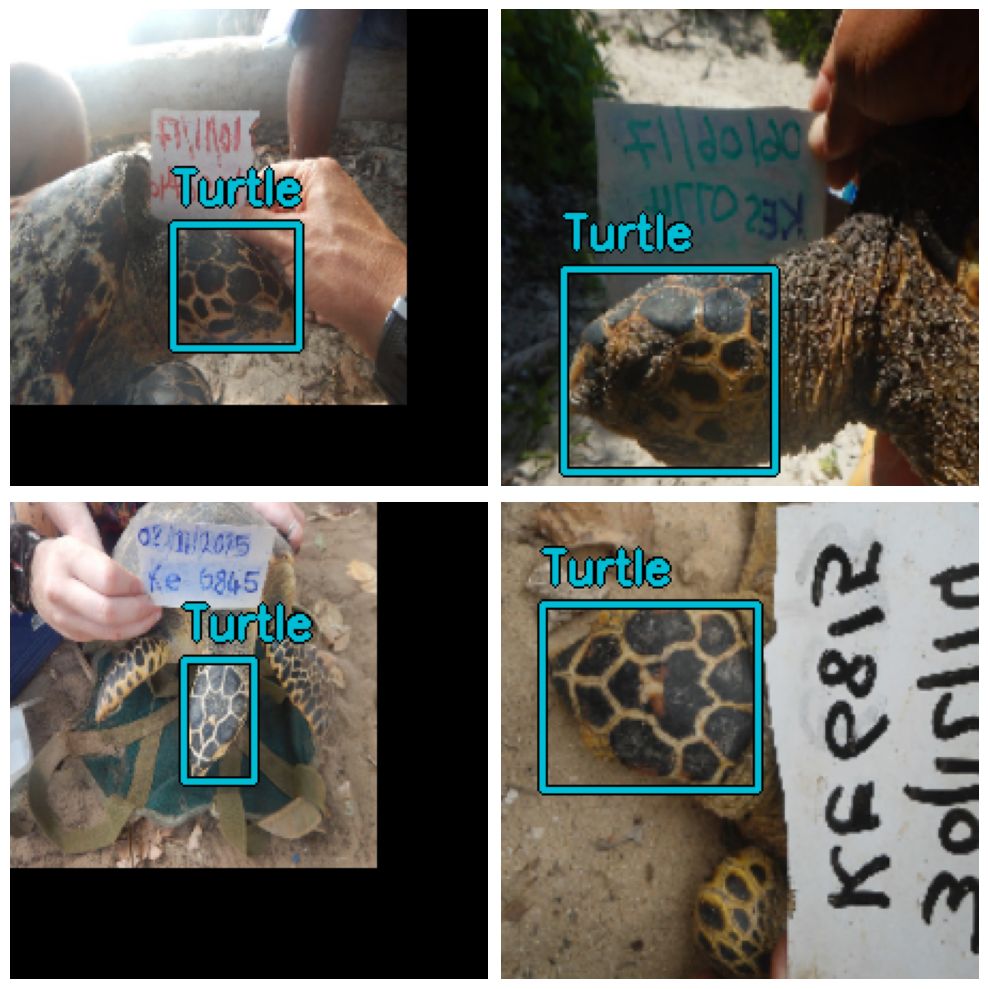

In [10]:
# Augmentation pipeline
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(224, 224), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
        #keras_cv.layers.RandomSaturation((0.4,0.6)),
        #keras_cv.layers.RandomHue(0.1, [0,255])
    ]
)

train_ds_aug = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
#train_ds = train_ds.map(lambda x: {'images':keras_cv.layers.RandomCutout(0.3,0.3)(x['images']), 'bounding_boxes':x['bounding_boxes']})
visualize_dataset(
    train_ds_aug, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

Finally, we unpack the dataset so that it can be processed by the network

In [30]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=1
    )

train_ds = train_ds_aug.map(dict_to_tuple)
#val_ds = val_ds.map(dict_to_tuple)
train_ds = train_ds.map(lambda x,y: (x, {'classes': y['classes'], 'boxes':y['boxes'] / 224}))

train = train_ds.prefetch(tf.data.AUTOTUNE)
val = val_ds.prefetch(tf.data.AUTOTUNE)

## Definition of the Model

Once we obtained the dataset, we need to define the hyperparameters of the model that we are going to train

In [44]:
INITIAL_LR = 1e-3
EPOCHS = 100

We need to define the metrics for evaluate the goodness of our training.
The most popular Object Detection metrics are COCO metrics, which were published alongside the MSCOCO dataset. However, in the competition, the Intersection over Union metric is used, so we are going to use it also for our training.

$$IoU = \frac{\text{Area of overlap}}{\text{Area of union}} = \frac{\text{Area of Intersection}}{\text{Ground Truth Area + Predicted Box Area - Intersection Area}}$$

In [42]:
# This function returns the iou for the boxes contained in y_pred and y_true
def compute_iou(y_pred, y_true):
    xA = tf.math.maximum(y_true[:,0], y_pred[:,0])
    yA = tf.math.maximum(y_true[:,1], y_pred[:,1])
    xB = tf.math.minimum(y_true[:,2], y_pred[:,2])
    yB = tf.math.minimum(y_true[:,3], y_pred[:,3])

    # epsilon to add to prevent division by 0
    eps = 1e-5

    inter_area = tf.math.minimum(tf.math.maximum(0, xB - xA + eps),224) * tf.math.minimum(tf.math.maximum(0,yB - yA + eps),224)

    union_area = (y_true[:,2] - y_true[:,0] + eps) * (y_true[:,3] - y_true[:,1] + eps) + (y_pred[:,2] - y_pred[:,0] + eps) * (y_pred[:,3] - y_pred[:,1] + eps) - inter_area

    iou = tf.reduce_sum(inter_area / tf.cast(union_area, tf.float32))

    return iou

# We define a custom callback to compute the validation IoU at the end each epoch
class IouMetricCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        super(IouMetricCallback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        logs['val_iou'] = float('inf')
        iou = 0
        samples = 0
        for image, label in val_ds:
            samples += tf.shape(image)[0]
            pred = model.predict(image)['boxes']
            pred = tf.reshape(pred, [-1,4]) * INPUT_SIZE_LEARNER
            label = label['boxes']
            label = tf.reshape(label, [-1,4])
            iou += compute_iou(pred,label)

        iou = iou / tf.cast(samples, tf.float32)
        logs['val_iou'] = np.round(iou, 5)

Both our training set and the metric we use are ready. Therefore, we have everything needed for starting the training of our network.
We define now models starting from several pre-trained backbones on the imagenet dataset treating object detection as a regression problem.
Differently from the SotA algorithms, the network predicts directly the 4 corners of the bounding box.

This approach has been applied only for educative purposes, since the results will be far from the SotA object detection models.

First of all, we define the number of regression heads and classification heads.

In [33]:
HEAD_BBOX_LAYERS = 3
HEAD_CLASS_LAYERS = 1

Now, we want to define a model that works like this:

1) Uses the backbone to process the input and extracts the features
2) Processes in parallel through the classification and regression heads the output
3) Flattens the output and processes it through some Fully Connected layers that eventually return the 4 corners of the bounding box

We do so by using the functional API of keras

In [37]:
# We are going to use the Functional API of Tensorflow to define a model
class Model(tf.keras.Model):
    
    def __init__(self, backbone:tf.keras.Model):
        
        inputs = tf.keras.layers.Input(shape=[224, 224, 3])
        backbone_res = backbone(inputs)
        
        # Classification Head
        for _ in range(HEAD_CLASS_LAYERS):
            layer = tf.keras.layers.Conv2D(256, 3, padding="same")(backbone_res)
            layer = tf.keras.layers.BatchNormalization()(layer)
            layer = tf.keras.layers.Activation(tf.keras.activations.relu)(layer)
        
        layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
        class_out = tf.keras.layers.Dense(1, activation='sigmoid')(layer)
        
        # Regression head
        for _ in range(HEAD_BBOX_LAYERS):
            layer = tf.keras.layers.Conv2D(256, 3, padding="same")(backbone_res)
            layer = tf.keras.layers.BatchNormalization()(layer)
            layer = tf.keras.layers.Activation(tf.keras.activations.relu)(layer)
            
            
        layer = tf.keras.layers.Conv2D(4, 3, padding="same")(layer)
        
        layer = tf.keras.layers.Flatten()(layer)
        layer = tf.keras.layers.Dense(64, activation='relu')(layer)
        layer = tf.keras.layers.Dropout(0.3)(layer)
        layer = tf.keras.layers.Dense(32, activation='relu')(layer)
        regr_out = tf.keras.layers.Dense(4, activation='sigmoid')(layer)
        regr_out = tf.reshape(regr_out, [-1,1,4])

        super().__init__(inputs=inputs, outputs={'classes':class_out, 'boxes':regr_out})

## Training

Once we defined the model class, we can download a pre-trained backbone, define the model and fine-tune it.

In [45]:
# We download the backbone
backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=[224,224,3], weights='imagenet')
# We freeze the weights to train only the part we attached after the network.
backbone.trainable = False

model = Model(backbone)

model.summary()

# Definition of learning rate and optimizer
lr = tf.keras.optimizers.schedules.CosineDecay(INITIAL_LR, EPOCHS * train_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, global_clipnorm=10)

model.compile(
    loss={'classes':tf.keras.losses.BinaryCrossentropy(), 'boxes':tf.keras.losses.Huber()},
    optimizer=optimizer
)

# We define an earlyStopping callback to stop training if the validation Intersection over Union value has been decreasing over the last N epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=10, restore_best_weights=True, mode='max')

# Fitting the model
model.fit(
    train,
    validation_data=val,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=EPOCHS,
    callbacks=[IouMetricCallback()]
)

# Saving the weights of the model
model.save_weights('./models/no_anchor_EffnetB0.tf', save_format='tf', overwrite=True)


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_22[0][0]']            
 )                                                                                                
                                                                                                  
 conv2d_53 (Conv2D)          (None, 7, 7, 256)            2949376   ['efficientnetb0[0][0]']      
                                                                                                  
 batch_normalization_43 (Ba  (None, 7, 7, 256)            1024      ['conv2d_53[0][0]']    

Epoch 4/100
66/66 [==============================] - 3s 47ms/step - loss: 0.0094 - tf.reshape_9_loss: 0.0039 - dense_40_loss: 0.0055 - val_loss: 130.3775 - val_tf.reshape_9_loss: 130.3717 - val_dense_40_loss: 0.0058 - val_iou: 0.5214
Epoch 5/100
66/66 [==============================] - 3s 47ms/step - loss: 0.0071 - tf.reshape_9_loss: 0.0034 - dense_40_loss: 0.0037 - val_loss: 130.3553 - val_tf.reshape_9_loss: 130.3512 - val_dense_40_loss: 0.0042 - val_iou: 0.5306
Epoch 6/100
66/66 [==============================] - 3s 47ms/step - loss: 0.0057 - tf.reshape_9_loss: 0.0031 - dense_40_loss: 0.0027 - val_loss: 130.3636 - val_tf.reshape_9_loss: 130.3607 - val_dense_40_loss: 0.0029 - val_iou: 0.5462
Epoch 7/100
66/66 [==============================] - 3s 47ms/step - loss: 0.0049 - tf.reshape_9_loss: 0.0029 - dense_40_loss: 0.0021 - val_loss: 130.3659 - val_tf.reshape_9_loss: 130.3638 - val_dense_40_loss: 0.0021 - val_iou: 0.5719
Epoch 8/100
66/66 [==============================] - 3s 46ms/ste

66/66 [==============================] - 3s 46ms/step - loss: 0.0031 - tf.reshape_9_loss: 0.0022 - dense_40_loss: 9.2563e-04 - val_loss: 130.3673 - val_tf.reshape_9_loss: 130.3663 - val_dense_40_loss: 9.4309e-04 - val_iou: 0.5856
Epoch 12/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0029 - tf.reshape_9_loss: 0.0021 - dense_40_loss: 7.8607e-04 - val_loss: 130.3572 - val_tf.reshape_9_loss: 130.3564 - val_dense_40_loss: 7.5120e-04 - val_iou: 0.5716
Epoch 13/100
66/66 [==============================] - 3s 45ms/step - loss: 0.0026 - tf.reshape_9_loss: 0.0019 - dense_40_loss: 6.8793e-04 - val_loss: 130.3688 - val_tf.reshape_9_loss: 130.3681 - val_dense_40_loss: 6.7856e-04 - val_iou: 0.5991
Epoch 14/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0026 - tf.reshape_9_loss: 0.0020 - dense_40_loss: 5.9269e-04 - val_loss: 130.3735 - val_tf.reshape_9_loss: 130.3729 - val_dense_40_loss: 5.8865e-04 - val_iou: 0.5783
Epoch 15/100
66/66 [=====================

66/66 [==============================] - 3s 46ms/step - loss: 0.0022 - tf.reshape_9_loss: 0.0018 - dense_40_loss: 3.7401e-04 - val_loss: 130.3793 - val_tf.reshape_9_loss: 130.3790 - val_dense_40_loss: 3.8093e-04 - val_iou: 0.5864
Epoch 19/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0022 - tf.reshape_9_loss: 0.0019 - dense_40_loss: 3.3297e-04 - val_loss: 130.3707 - val_tf.reshape_9_loss: 130.3704 - val_dense_40_loss: 3.3627e-04 - val_iou: 0.5970
Epoch 20/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0020 - tf.reshape_9_loss: 0.0017 - dense_40_loss: 3.0753e-04 - val_loss: 130.3807 - val_tf.reshape_9_loss: 130.3804 - val_dense_40_loss: 3.0271e-04 - val_iou: 0.5997
Epoch 21/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0019 - tf.reshape_9_loss: 0.0016 - dense_40_loss: 2.8139e-04 - val_loss: 130.3568 - val_tf.reshape_9_loss: 130.3566 - val_dense_40_loss: 2.6860e-04 - val_iou: 0.6017
Epoch 22/100
66/66 [=====================

66/66 [==============================] - 3s 46ms/step - loss: 0.0016 - tf.reshape_9_loss: 0.0014 - dense_40_loss: 1.9737e-04 - val_loss: 130.3683 - val_tf.reshape_9_loss: 130.3681 - val_dense_40_loss: 1.9616e-04 - val_iou: 0.6031
Epoch 26/100
66/66 [==============================] - 3s 46ms/step - loss: -0.0049 - tf.reshape_9_loss: 0.0018 - dense_40_loss: -0.0068 - val_loss: 130.3512 - val_tf.reshape_9_loss: 130.3509 - val_dense_40_loss: 2.7782e-04 - val_iou: 0.5527
Epoch 27/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0023 - tf.reshape_9_loss: 0.0017 - dense_40_loss: 6.0619e-04 - val_loss: 130.3657 - val_tf.reshape_9_loss: 130.3655 - val_dense_40_loss: 2.1106e-04 - val_iou: 0.5695
Epoch 28/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0019 - tf.reshape_9_loss: 0.0015 - dense_40_loss: 3.6678e-04 - val_loss: 130.3718 - val_tf.reshape_9_loss: 130.3716 - val_dense_40_loss: 1.8012e-04 - val_iou: 0.6123
Epoch 29/100
66/66 [=======================

Epoch 33/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0016 - tf.reshape_9_loss: 0.0014 - dense_40_loss: 1.6009e-04 - val_loss: 130.3659 - val_tf.reshape_9_loss: 130.3658 - val_dense_40_loss: 1.0754e-04 - val_iou: 0.6232
Epoch 34/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0015 - tf.reshape_9_loss: 0.0014 - dense_40_loss: 1.4385e-04 - val_loss: 130.3638 - val_tf.reshape_9_loss: 130.3638 - val_dense_40_loss: 9.9636e-05 - val_iou: 0.5995
Epoch 35/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0015 - tf.reshape_9_loss: 0.0013 - dense_40_loss: 1.3072e-04 - val_loss: 130.3724 - val_tf.reshape_9_loss: 130.3723 - val_dense_40_loss: 9.0382e-05 - val_iou: 0.6030
Epoch 36/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0015 - tf.reshape_9_loss: 0.0014 - dense_40_loss: 1.1656e-04 - val_loss: 130.3598 - val_tf.reshape_9_loss: 130.3598 - val_dense_40_loss: 8.2160e-05 - val_iou: 0.6177
Epoch 37/100
66/66 [========

66/66 [==============================] - 3s 45ms/step - loss: 0.0015 - tf.reshape_9_loss: 0.0014 - dense_40_loss: 8.7148e-05 - val_loss: 130.3668 - val_tf.reshape_9_loss: 130.3667 - val_dense_40_loss: 5.9397e-05 - val_iou: 0.6227
Epoch 41/100
66/66 [==============================] - 3s 45ms/step - loss: 0.0014 - tf.reshape_9_loss: 0.0013 - dense_40_loss: 7.7809e-05 - val_loss: 130.3736 - val_tf.reshape_9_loss: 130.3735 - val_dense_40_loss: 5.5324e-05 - val_iou: 0.6422
Epoch 42/100
66/66 [==============================] - 3s 45ms/step - loss: 0.0013 - tf.reshape_9_loss: 0.0012 - dense_40_loss: 7.3602e-05 - val_loss: 130.3681 - val_tf.reshape_9_loss: 130.3681 - val_dense_40_loss: 5.1771e-05 - val_iou: 0.6400
Epoch 43/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0013 - tf.reshape_9_loss: 0.0012 - dense_40_loss: 6.8977e-05 - val_loss: 130.3631 - val_tf.reshape_9_loss: 130.3630 - val_dense_40_loss: 4.9458e-05 - val_iou: 0.6434
Epoch 44/100
66/66 [=====================

66/66 [==============================] - 3s 45ms/step - loss: 0.0012 - tf.reshape_9_loss: 0.0011 - dense_40_loss: 5.5127e-05 - val_loss: 130.3701 - val_tf.reshape_9_loss: 130.3701 - val_dense_40_loss: 3.9671e-05 - val_iou: 0.6266
Epoch 48/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0013 - tf.reshape_9_loss: 0.0012 - dense_40_loss: 5.0010e-05 - val_loss: 130.3708 - val_tf.reshape_9_loss: 130.3708 - val_dense_40_loss: 3.8066e-05 - val_iou: 0.6364
Epoch 49/100
66/66 [==============================] - 3s 45ms/step - loss: 0.0012 - tf.reshape_9_loss: 0.0011 - dense_40_loss: 5.0136e-05 - val_loss: 130.3688 - val_tf.reshape_9_loss: 130.3688 - val_dense_40_loss: 3.5840e-05 - val_iou: 0.6202
Epoch 50/100
66/66 [==============================] - 3s 45ms/step - loss: 0.0012 - tf.reshape_9_loss: 0.0011 - dense_40_loss: 4.6050e-05 - val_loss: 130.3625 - val_tf.reshape_9_loss: 130.3625 - val_dense_40_loss: 3.5014e-05 - val_iou: 0.6180
Epoch 51/100
66/66 [=====================

66/66 [==============================] - 3s 46ms/step - loss: 0.0013 - tf.reshape_9_loss: 0.0012 - dense_40_loss: 3.6266e-05 - val_loss: 130.3835 - val_tf.reshape_9_loss: 130.3835 - val_dense_40_loss: 2.7492e-05 - val_iou: 0.6008
Epoch 55/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0012 - tf.reshape_9_loss: 0.0012 - dense_40_loss: 3.6800e-05 - val_loss: 130.3645 - val_tf.reshape_9_loss: 130.3645 - val_dense_40_loss: 2.6119e-05 - val_iou: 0.6070
Epoch 56/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0011 - tf.reshape_9_loss: 0.0011 - dense_40_loss: 3.3402e-05 - val_loss: 130.3616 - val_tf.reshape_9_loss: 130.3616 - val_dense_40_loss: 2.5501e-05 - val_iou: 0.6241
Epoch 57/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0011 - tf.reshape_9_loss: 0.0010 - dense_40_loss: 3.2943e-05 - val_loss: 130.3623 - val_tf.reshape_9_loss: 130.3623 - val_dense_40_loss: 2.4199e-05 - val_iou: 0.6372
Epoch 58/100
66/66 [=====================

66/66 [==============================] - 3s 45ms/step - loss: 0.0011 - tf.reshape_9_loss: 0.0011 - dense_40_loss: 2.5463e-05 - val_loss: 130.3650 - val_tf.reshape_9_loss: 130.3649 - val_dense_40_loss: 2.0005e-05 - val_iou: 0.6572
Epoch 62/100
66/66 [==============================] - 3s 45ms/step - loss: 0.0012 - tf.reshape_9_loss: 0.0012 - dense_40_loss: 2.4578e-05 - val_loss: 130.3608 - val_tf.reshape_9_loss: 130.3608 - val_dense_40_loss: 1.8891e-05 - val_iou: 0.6266
Epoch 63/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0011 - tf.reshape_9_loss: 0.0010 - dense_40_loss: 2.4084e-05 - val_loss: 130.3726 - val_tf.reshape_9_loss: 130.3726 - val_dense_40_loss: 1.7798e-05 - val_iou: 0.6406
Epoch 64/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0010 - tf.reshape_9_loss: 9.9476e-04 - dense_40_loss: 2.2501e-05 - val_loss: 130.3664 - val_tf.reshape_9_loss: 130.3664 - val_dense_40_loss: 1.7703e-05 - val_iou: 0.6487
Epoch 65/100
66/66 [=================

Epoch 69/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0010 - tf.reshape_9_loss: 0.0010 - dense_40_loss: 1.7809e-05 - val_loss: 130.3711 - val_tf.reshape_9_loss: 130.3711 - val_dense_40_loss: 1.4194e-05 - val_iou: 0.6486
Epoch 70/100
66/66 [==============================] - 3s 45ms/step - loss: 9.7907e-04 - tf.reshape_9_loss: 9.6164e-04 - dense_40_loss: 1.7430e-05 - val_loss: 130.3708 - val_tf.reshape_9_loss: 130.3708 - val_dense_40_loss: 1.4256e-05 - val_iou: 0.6300
Epoch 71/100
66/66 [==============================] - 3s 45ms/step - loss: 0.0010 - tf.reshape_9_loss: 9.9750e-04 - dense_40_loss: 1.6272e-05 - val_loss: 130.3729 - val_tf.reshape_9_loss: 130.3729 - val_dense_40_loss: 1.3419e-05 - val_iou: 0.6477
Epoch 72/100
66/66 [==============================] - 3s 46ms/step - loss: 0.0011 - tf.reshape_9_loss: 0.0011 - dense_40_loss: 1.5772e-05 - val_loss: 130.3728 - val_tf.reshape_9_loss: 130.3728 - val_dense_40_loss: 1.2659e-05 - val_iou: 0.6574
Epoch 73/100
66/

66/66 [==============================] - 3s 45ms/step - loss: 9.4875e-04 - tf.reshape_9_loss: 9.3514e-04 - dense_40_loss: 1.3611e-05 - val_loss: 130.3740 - val_tf.reshape_9_loss: 130.3740 - val_dense_40_loss: 1.0719e-05 - val_iou: 0.6445
Epoch 77/100
66/66 [==============================] - 3s 45ms/step - loss: 9.2268e-04 - tf.reshape_9_loss: 9.0947e-04 - dense_40_loss: 1.3211e-05 - val_loss: 130.3674 - val_tf.reshape_9_loss: 130.3674 - val_dense_40_loss: 1.0525e-05 - val_iou: 0.6515
Epoch 78/100
66/66 [==============================] - 3s 45ms/step - loss: 9.2877e-04 - tf.reshape_9_loss: 9.1594e-04 - dense_40_loss: 1.2831e-05 - val_loss: 130.3675 - val_tf.reshape_9_loss: 130.3675 - val_dense_40_loss: 9.9049e-06 - val_iou: 0.6570
Epoch 79/100
66/66 [==============================] - 3s 45ms/step - loss: 8.4910e-04 - tf.reshape_9_loss: 8.3688e-04 - dense_40_loss: 1.2224e-05 - val_loss: 130.3721 - val_tf.reshape_9_loss: 130.3721 - val_dense_40_loss: 9.5614e-06 - val_iou: 0.6572
Epoch 80/

66/66 [==============================] - 3s 45ms/step - loss: 8.5500e-04 - tf.reshape_9_loss: 8.4483e-04 - dense_40_loss: 1.0166e-05 - val_loss: 130.3717 - val_tf.reshape_9_loss: 130.3717 - val_dense_40_loss: 8.0138e-06 - val_iou: 0.6489
Epoch 84/100
66/66 [==============================] - 3s 45ms/step - loss: 8.6459e-04 - tf.reshape_9_loss: 8.5385e-04 - dense_40_loss: 1.0740e-05 - val_loss: 130.3642 - val_tf.reshape_9_loss: 130.3642 - val_dense_40_loss: 8.0542e-06 - val_iou: 0.6458
Epoch 85/100
66/66 [==============================] - 3s 45ms/step - loss: 8.7760e-04 - tf.reshape_9_loss: 8.6814e-04 - dense_40_loss: 9.4595e-06 - val_loss: 130.3650 - val_tf.reshape_9_loss: 130.3650 - val_dense_40_loss: 7.4897e-06 - val_iou: 0.6637
Epoch 86/100
66/66 [==============================] - 3s 46ms/step - loss: 8.1742e-04 - tf.reshape_9_loss: 8.0825e-04 - dense_40_loss: 9.1707e-06 - val_loss: 130.3757 - val_tf.reshape_9_loss: 130.3757 - val_dense_40_loss: 7.3568e-06 - val_iou: 0.6539
Epoch 87/

66/66 [==============================] - 3s 46ms/step - loss: 8.3752e-04 - tf.reshape_9_loss: 8.2938e-04 - dense_40_loss: 8.1414e-06 - val_loss: 130.3645 - val_tf.reshape_9_loss: 130.3645 - val_dense_40_loss: 6.3474e-06 - val_iou: 0.6701
Epoch 91/100
66/66 [==============================] - 3s 45ms/step - loss: 8.3750e-04 - tf.reshape_9_loss: 8.3022e-04 - dense_40_loss: 7.2846e-06 - val_loss: 130.3676 - val_tf.reshape_9_loss: 130.3676 - val_dense_40_loss: 6.1114e-06 - val_iou: 0.6610
Epoch 92/100
66/66 [==============================] - 3s 45ms/step - loss: 8.2738e-04 - tf.reshape_9_loss: 8.2016e-04 - dense_40_loss: 7.2180e-06 - val_loss: 130.3804 - val_tf.reshape_9_loss: 130.3804 - val_dense_40_loss: 5.8250e-06 - val_iou: 0.6609
Epoch 93/100
66/66 [==============================] - 3s 45ms/step - loss: 7.7316e-04 - tf.reshape_9_loss: 7.6631e-04 - dense_40_loss: 6.8503e-06 - val_loss: 130.3581 - val_tf.reshape_9_loss: 130.3581 - val_dense_40_loss: 5.5835e-06 - val_iou: 0.6672
Epoch 94/

66/66 [==============================] - 3s 45ms/step - loss: 7.6934e-04 - tf.reshape_9_loss: 7.6347e-04 - dense_40_loss: 5.8675e-06 - val_loss: 130.3695 - val_tf.reshape_9_loss: 130.3695 - val_dense_40_loss: 4.7013e-06 - val_iou: 0.6730
Epoch 98/100
66/66 [==============================] - 3s 46ms/step - loss: 8.4114e-04 - tf.reshape_9_loss: 8.3565e-04 - dense_40_loss: 5.4907e-06 - val_loss: 130.3736 - val_tf.reshape_9_loss: 130.3736 - val_dense_40_loss: 4.5803e-06 - val_iou: 0.6588
Epoch 99/100
66/66 [==============================] - 3s 45ms/step - loss: 8.1774e-04 - tf.reshape_9_loss: 8.1207e-04 - dense_40_loss: 5.6749e-06 - val_loss: 130.3537 - val_tf.reshape_9_loss: 130.3537 - val_dense_40_loss: 4.4457e-06 - val_iou: 0.6540
Epoch 100/100
66/66 [==============================] - 3s 46ms/step - loss: 7.8797e-04 - tf.reshape_9_loss: 7.8273e-04 - dense_40_loss: 5.2441e-06 - val_loss: 130.3656 - val_tf.reshape_9_loss: 130.3656 - val_dense_40_loss: 4.2310e-06 - val_iou: 0.6743


## Visualization over evaluation dataset for every model

Once we have trained all the models, we can perform inference over the validation dataset to get an estimate of the performance for each model.

In [46]:
visualization_ds = val.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

Let us write a function to perform inference

In [47]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)

    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        line_thickness=1,
        legend=True,
        font_scale=0.4,
        class_mapping=class_mapping,
    )


Now we're ready to see the predictions of each model so that we can easily make a comparison.
When performing inference you need Non Maximum Suppression: it's a technique consisting in removing all the bounding boxes for the objects that have been already predicted (better) by the network or predictions that are over background elements or which the network is not confident about.

Detections over validation set
1/1 [==============================] - 1s 662ms/step


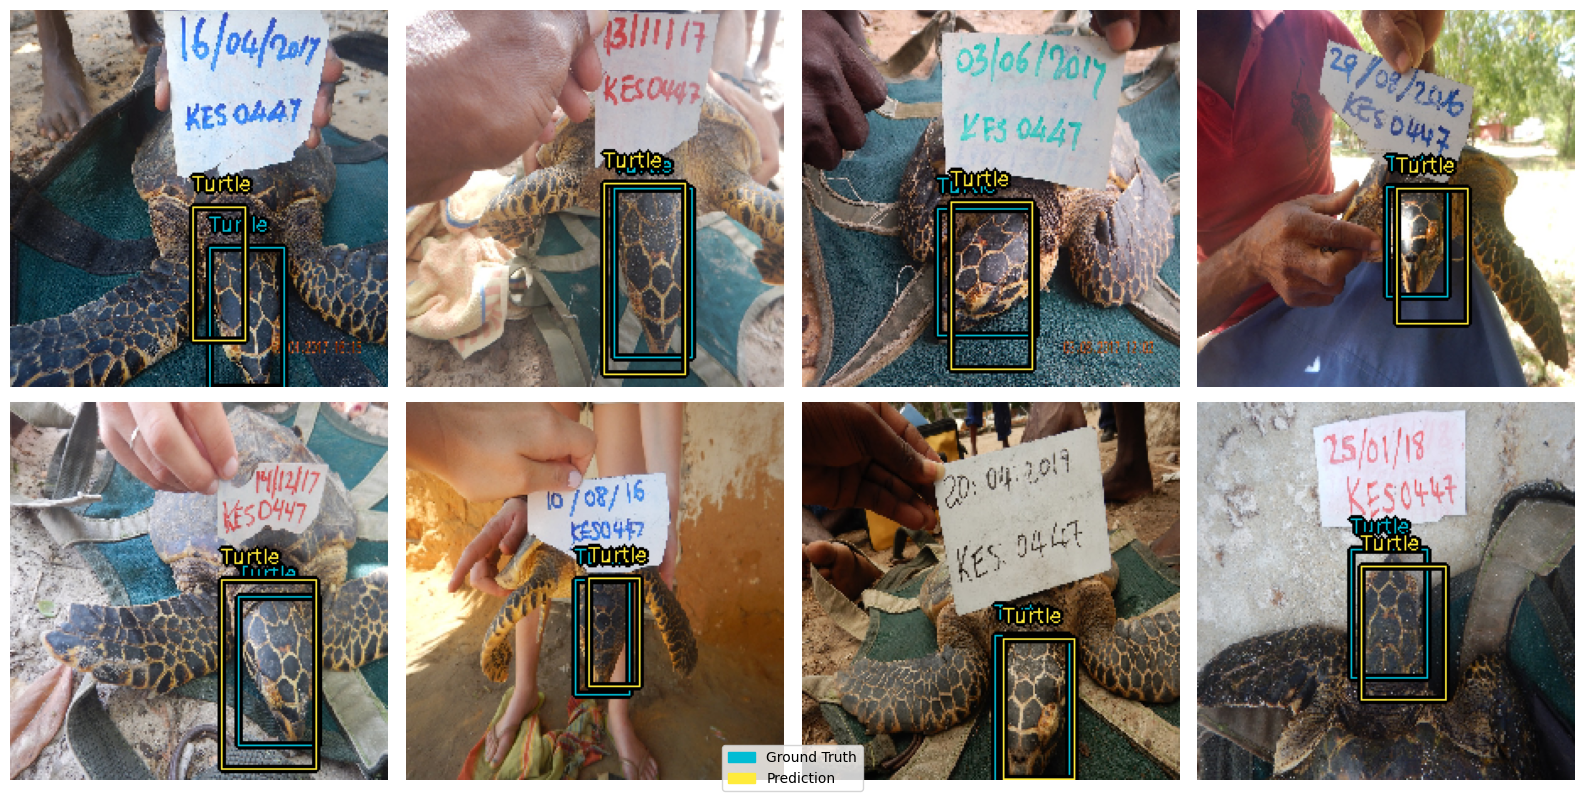

In [166]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=[224,224,3], weights='imagenet')

model = Model(backbone)

model.load_weights('./models/no_anchor_EffnetB0.tf')

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=False,
    iou_threshold=0.2,
    confidence_threshold=0.1,
    max_detections=1
)

print(f'Detections over validation set')

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xyxy")


In [49]:
name = 'no_anchor_EffnetB0'

backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=[224,224,3], weights='imagenet')

model = Model(backbone)

model.load_weights('./models/no_anchor_EffnetB0.tf')

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=False,
    iou_threshold=0.5,
    confidence_threshold=0,
    max_detections=1
)

iou = 0
samples = 0
for image, label in visualization_ds:
    samples += tf.shape(image)[0]
    pred = model.predict(image)['boxes']
    pred = tf.reshape(pred, [-1,4]) * INPUT_SIZE_LEARNER
    label = label['boxes']
    label = tf.reshape(label, [-1,4])
    iou += compute_iou(pred,label)

iou = iou / tf.cast(samples, tf.float32)
print(f'IoU for model {name} is: {iou}')

1/1 [==============================] - 0s 14ms/step
IoU for model no_anchor_EffnetB0 is: 0.6743040084838867


***

## Inference on the test dataset

We can finally perform the prediction over the test set so that it can be evalutated on the Test dataset used by Zindi.

First of all, we need to read the file containing the Images for which we need to perform the prediction as a pandas dataset.

In [20]:
ss = pd.read_csv('./dataset/SampleSubmission.csv')
ss.head(3)

Image_ID  x  y  w  h
0  4863D911  0  0  0  0
1  6DD3ADD5  0  0  0  0
2  E8DC4D6A  0  0  0  0

Given the file names, using the load_dataset() function, we load the test dataset ready for the inference stage.

In [21]:
test_dataset,_  = load_dataset(training=False)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

[INFO] loading dataset...
(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 20.,   8.,   8.],
        [ 21.,   9.,   9.],
        [ 21.,   9.,   9.],
        ...,
        [ 84.,  64.,  29.],
        [ 86.,  65.,  34.],
        [ 85.,  66.,  36.]],

       [[ 18.,   8.,   7.],
        [ 19.,   9.,   8.],
        [ 19.,   9.,   8.],
        ...,
        [ 92.,  73.,  41.],
        [100.,  81.,  49.],
        [100.,  84.,  51.]],

       [[ 14.,   6.,   4.],
        [ 16.,   8.,   6.],
        [ 17.,   9.,   7.],
        ...,
        [ 95.,  78.,  48.],
        [104.,  90.,  51.],
        [115., 102.,  58.]],

       ...,

       [[ 42.,  43.,  45.],
        [ 42.,  43.,  45.],
        [ 42.,  43.,  45.],
        ...,
        [ 40.,  32.,  30.],
        [ 34.,  29.,  23.],
        [ 30.,  26.,  17.]],

       [[ 44.,  45.,  47.],
        [ 44.,  45.,  47.],
        [ 44.,  45.,  47.],
        ...,
        [ 24.,  29.,  33.],
        [ 25.,  35.,  37.],
        [ 28.,  40.,

Now we define the Non Maximum Suppression layer for the processing of the prediction of the network.

In [24]:
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
    max_detections=1
)

We perform now the prediction with the network and scale it down to the range [0,1] since this is the format required for the solution.

In [35]:
predictions = tf.reshape(tf.constant([]), [-1,4])

for image, size in test_dataset:
    size = tf.cast(size, tf.float32)
    pred = model.predict(image)['boxes']
    pred = pred.to_tensor()
    pred = tf.reshape(pred, [-1,4])
    x1 = pred[:,0]
    x2 = pred[:,2]
    y1 = pred[:,1]
    y2 = pred[:,3]
    
    w = x2 - x1
    h = y2 - y1
    
    batch_preds = tf.reshape(tf.stack([x1,y1,w,h], axis=1), [-1,4])
    predictions = tf.concat([predictions,batch_preds], axis=0)

ss.loc[:,['x', 'y', 'w', 'h']] = np.array(predictions)

1/1 [==============================] - 0s 51ms/step
tf.Tensor(
[0.23906957 0.34028095 0.35064656 0.33182892 0.3595218  0.48331752
 0.37614518 0.33392498 0.36245123 0.15310968 0.34055963 0.32618925
 0.36634383 0.34427133 0.31622192 0.41363075], shape=(16,), dtype=float32) tf.Tensor(
[0.33030754 0.31869072 0.54106617 0.5304163  0.4711267  0.4406062
 0.4192694  0.51788837 0.4093854  0.33080897 0.48669434 0.47831067
 0.49165148 0.5264169  0.21204539 0.5484079 ], shape=(16,), dtype=float32) tf.Tensor(
[0.4956166  0.36941534 0.452196   0.42415485 0.42461735 0.14921209
 0.41209197 0.31696787 0.471944   0.33585376 0.25343177 0.28761515
 0.24333301 0.34885588 0.40013912 0.2816113 ], shape=(16,), dtype=float32) tf.Tensor(
[0.52434635 0.47762322 0.43563175 0.40887678 0.41113523 0.20945212
 0.33753    0.29831982 0.44254836 0.29674014 0.23881924 0.2782322
 0.32365727 0.41497368 0.34123117 0.30710953], shape=(16,), dtype=float32)
tf.Tensor(
[[0.23906957 0.33030754 0.4956166  0.52434635]
 [0.34028095

1/1 [==============================] - 0s 53ms/step
tf.Tensor(
[0.4805101  0.3748736  0.46360585 0.41450405 0.39020577 0.39114586
 0.40565023 0.5981328  0.49055868 0.4505244  0.35733318 1.5661951
 0.33630785 0.45493445 0.5826392  0.42112586], shape=(16,), dtype=float32) tf.Tensor(
[ 0.4078088   0.34785193  0.51537675  0.5331999   0.3930378   0.36867592
  0.44190916  0.32596207  0.5801044   0.5076098   0.42196503  1.1503439
  0.41039994  0.3634946  -0.08076597  0.36761197], shape=(16,), dtype=float32) tf.Tensor(
[0.15151438 0.23225513 0.24448904 0.20429891 0.24952802 0.33559313
 0.3179346  0.21130443 0.16227669 0.1427244  0.36039793 0.44747484
 0.22036073 0.34998664 0.6734992  0.1517497 ], shape=(16,), dtype=float32) tf.Tensor(
[0.27011147 0.25696272 0.47940445 0.39350444 0.4954278  0.32439658
 0.4270604  0.4617502  0.42814523 0.36572033 0.38120082 0.9001701
 0.2340137  0.38804463 0.3585158  0.22982165], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.4805101   0.4078088   0.15151438  0.270

1/1 [==============================] - 0s 48ms/step
tf.Tensor(
[0.34165832 0.4359788  0.39959335 0.3989087  0.4342466  0.56839764
 0.27410737 0.32357556 0.3955402  0.42719486 0.43011922 0.49532172
 0.54750985 0.         0.46675187 0.39361045], shape=(16,), dtype=float32) tf.Tensor(
[0.4203444  0.44922087 0.27159783 0.53243214 0.42121634 0.47158232
 0.54788166 0.32563442 0.41431832 0.45724624 0.4527946  0.3918376
 0.4224445  0.         0.55419457 0.5312968 ], shape=(16,), dtype=float32) tf.Tensor(
[0.21088848 0.21478763 0.22817856 0.39358923 0.37377673 0.11281699
 0.36478427 0.20697886 0.26988736 0.2106851  0.27084613 0.24171129
 0.1726641  0.         0.21462023 0.16265717], shape=(16,), dtype=float32) tf.Tensor(
[0.25440907 0.23888502 0.22381121 0.40494388 0.44528434 0.1759583
 0.38897908 0.32587552 0.28431582 0.40111542 0.4938541  0.29763842
 0.36400887 0.         0.42805403 0.344702  ], shape=(16,), dtype=float32)
tf.Tensor(
[[0.34165832 0.4203444  0.21088848 0.25440907]
 [0.4359788 

1/1 [==============================] - 0s 49ms/step
tf.Tensor(
[0.51811224 0.39771459 0.43929    0.3139916  0.37857032 0.42989677
 0.3965486  0.46102265 0.6239534  0.39288726 0.45905352 0.36958572
 0.36022115 0.5235972  0.6357922  0.38797358], shape=(16,), dtype=float32) tf.Tensor(
[0.41514382 0.49260044 0.32177442 0.32780266 0.50236315 0.33383268
 0.47320276 0.5661683  0.5265523  0.39527702 0.46792927 0.28140602
 0.36100572 0.35155964 0.3194112  0.50044507], shape=(16,), dtype=float32) tf.Tensor(
[0.4769557  0.3182933  0.39285058 0.4314748  0.3311718  0.37325722
 0.32649836 0.4235712  0.15765083 0.18216243 0.16852939 0.37931314
 0.14895171 0.13789743 0.34817123 0.25402394], shape=(16,), dtype=float32) tf.Tensor(
[0.41045246 0.28696698 0.3949476  0.36979562 0.35693645 0.34329325
 0.34393954 0.4053315  0.11051834 0.2557835  0.35401812 0.35545143
 0.33395696 0.2717492  0.31541505 0.4155606 ], shape=(16,), dtype=float32)
tf.Tensor(
[[0.51811224 0.41514382 0.4769557  0.41045246]
 [0.397714

1/1 [==============================] - 0s 58ms/step
tf.Tensor(
[0.42890754 0.49358007 0.40770343 0.4993325  0.35607028 0.5690778
 2.0463283  0.         0.53392214 0.45121384 0.41684422 0.6232551
 0.47377756 0.38187367 0.48409113 0.22320859], shape=(16,), dtype=float32) tf.Tensor(
[ 0.43473217  0.3781745   0.42275524  0.6128354   0.43333212  0.39514336
 -0.0098576   0.          0.50789565  0.41376862  0.26057333  0.6293476
  0.5904595   0.5319973   0.34511584  0.3241555 ], shape=(16,), dtype=float32) tf.Tensor(
[0.19512448 0.1550971  0.20845136 0.18901706 0.2582544  0.1955288
 0.01947808 0.         0.11609638 0.1884467  0.45757988 0.29749143
 0.30328408 0.2843927  0.29569247 0.3647474 ], shape=(16,), dtype=float32) tf.Tensor(
[0.4856288  0.35601273 0.53884697 0.3105138  0.53984916 0.28864107
 0.55044305 0.         0.17472589 0.24334154 0.5848006  0.37703413
 0.38614982 0.31153858 0.46838754 0.34169543], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.42890754  0.43473217  0.19512448  0.4856

1/1 [==============================] - 0s 48ms/step
tf.Tensor(
[0.48780146 0.5421174  0.4094505  0.40096822 0.4686358  0.5011195
 0.51617396 0.48015872 0.44300693 0.3226398  0.4235652  0.4408733
 0.33262357 0.38775235 0.         0.50709945], shape=(16,), dtype=float32) tf.Tensor(
[0.50512505 0.23712392 0.27372333 0.22478907 0.53496295 0.46656016
 0.45690203 0.45270416 0.44650623 0.46213266 0.44688192 0.34590957
 0.4996063  0.27889746 0.         0.41851917], shape=(16,), dtype=float32) tf.Tensor(
[0.25297132 0.2777158  0.40470836 0.4217743  0.1330775  0.1434536
 0.2084288  0.3802761  0.29075688 0.32297042 0.19866788 0.28324196
 0.22187886 0.35419387 0.         0.11276513], shape=(16,), dtype=float32) tf.Tensor(
[0.28246212 0.28524327 0.614105   0.5858284  0.17348874 0.18023148
 0.2569539  0.4018052  0.29153523 0.3793474  0.25122258 0.30906537
 0.3020162  0.5585157  0.         0.20062903], shape=(16,), dtype=float32)
tf.Tensor(
[[0.48780146 0.50512505 0.25297132 0.28246212]
 [0.5421174  

1/1 [==============================] - 0s 48ms/step
tf.Tensor(
[0.52190727 0.34490862 0.50014734 0.43288103 0.51451534 0.4186069
 0.56785625 0.42121744 0.3343048  0.4172256  0.3898058  0.41706386
 0.5552057  0.18585971 0.3452732  0.37759587], shape=(16,), dtype=float32) tf.Tensor(
[0.518944   0.4997992  0.5336415  0.47333264 0.43836382 0.52209973
 0.43354794 0.6362305  0.39361742 0.41108578 0.6508489  0.496074
 0.50241625 0.413016   0.40751132 0.6024665 ], shape=(16,), dtype=float32) tf.Tensor(
[0.1389814  0.26950613 0.30604374 0.19167128 0.17325878 0.16675267
 0.15035534 0.21482193 0.45617056 0.36278027 0.33505774 0.27275774
 0.29486817 0.47336575 0.36651242 0.24077174], shape=(16,), dtype=float32) tf.Tensor(
[0.27157664 0.46567464 0.31696987 0.42167354 0.34583965 0.37783557
 0.20569947 0.2742529  0.40818176 0.57360053 0.3552677  0.33399895
 0.48928112 0.4588574  0.5785322  0.40570754], shape=(16,), dtype=float32)
tf.Tensor(
[[0.52190727 0.518944   0.1389814  0.27157664]
 [0.34490862 

1/1 [==============================] - 0s 48ms/step
tf.Tensor(
[0.40982598 0.3853293  0.37912294 0.33126912 0.40553805 0.40668184
 0.51636887 0.43270472 0.32485458 0.46267343 0.47636673 0.52551925
 0.45414737 0.32770798 0.23932695 0.37185764], shape=(16,), dtype=float32) tf.Tensor(
[ 0.6347003   0.51154435  0.3444379  -0.00633507  0.11308626  0.5274795
  0.44165277  0.3289556   0.4812762   0.44933996  0.4990141   0.43448043
  0.4946995   0.355608    0.28548354  0.37196636], shape=(16,), dtype=float32) tf.Tensor(
[0.2283805  0.19512695 0.28429338 0.27583936 0.27222547 0.18563575
 0.27120686 0.3167846  0.37401763 0.27172798 0.19751301 0.37362903
 0.38501844 0.3103449  0.3341841  0.3271643 ], shape=(16,), dtype=float32) tf.Tensor(
[0.374869   0.4262442  0.5483295  0.37748972 0.3863537  0.24577785
 0.36505824 0.33378643 0.35109347 0.36788318 0.37226894 0.37243897
 0.4055896  0.39038247 0.35645002 0.55161655], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.40982598  0.6347003   0.2283805   0.3

1/1 [==============================] - 0s 48ms/step
tf.Tensor(
[0.21219397 0.5050983  0.5304489  0.6703614  0.2339709  0.30430654
 0.2260817  0.33393463 0.08113415 0.37927622 0.49732834 0.53226477
 0.4957853  0.3791006  0.44693688 0.31310245], shape=(16,), dtype=float32) tf.Tensor(
[ 0.35514838  0.5495267   0.4237881  -0.13202645  0.35804838  0.40808386
  0.14470814  0.14432737  0.36934263  0.42653397  0.34149745  0.46533543
  0.5885296   0.30563757  0.3243099   0.40524408], shape=(16,), dtype=float32) tf.Tensor(
[0.41618907 0.24871725 0.20288998 0.13420212 0.32593018 0.27723882
 0.4531223  0.3371928  0.4263817  0.22111279 0.16053939 0.19626045
 0.19405544 0.43914738 0.3820782  0.30810592], shape=(16,), dtype=float32) tf.Tensor(
[0.430718   0.3755259  0.2905623  0.3366701  0.34231615 0.29471928
 0.5500974  0.47015962 0.5932416  0.24741563 0.19917116 0.24393982
 0.23031372 0.56248176 0.3592831  0.595464  ], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.21219397  0.35514838  0.41618907  0.

1/1 [==============================] - 0s 49ms/step
tf.Tensor(
[0.44920722 0.5044017  0.47733763 0.44732693 0.01081072 0.15003487
 0.50175315 0.6019934  0.49890512 0.4278778  0.34819412 0.08457466
 0.38543293 0.4623731  0.56470394 0.11137033], shape=(16,), dtype=float32) tf.Tensor(
[0.43586442 0.41335157 0.5135558  0.42256123 0.4813746  0.48418933
 0.48462555 0.52040565 0.47315767 0.3727047  0.15392487 0.40574387
 0.57898265 0.6040788  0.39583942 0.40786043], shape=(16,), dtype=float32) tf.Tensor(
[0.34403238 0.20955592 0.17776737 0.15039977 0.28391397 0.23937696
 0.1748724  0.17546135 0.12699217 0.1706396  0.24682438 0.38716957
 0.16413793 0.16702506 0.30476147 0.35676685], shape=(16,), dtype=float32) tf.Tensor(
[0.35064647 0.449994   0.43070465 0.33089137 0.51623523 0.48828614
 0.40321526 0.39404553 0.31289425 0.37797138 0.3169108  0.43699077
 0.31826591 0.38463676 0.28963003 0.45265457], shape=(16,), dtype=float32)
tf.Tensor(
[[0.44920722 0.43586442 0.34403238 0.35064647]
 [0.504401

1/1 [==============================] - 0s 50ms/step
tf.Tensor(
[0.26337323 0.2507504  0.43432137 0.44487557 0.41237774 0.45637298
 0.35214967 0.43497524 0.42657444 0.47215158 0.3610359  0.37550157
 0.4304258  0.41907832 0.46981907 0.5421469 ], shape=(16,), dtype=float32) tf.Tensor(
[0.3364487  0.55169594 0.30914885 0.2946827  0.47437    0.45722845
 0.55467767 0.51627725 0.4300881  0.53808975 0.3643897  0.4573893
 0.3420755  0.51320165 0.3795484  0.5544991 ], shape=(16,), dtype=float32) tf.Tensor(
[0.31327835 0.31138965 0.34101078 0.39138374 0.21263358 0.120143
 0.1975404  0.20887133 0.32147107 0.21166688 0.2280474  0.31824934
 0.45632645 0.19152513 0.12094992 0.16031319], shape=(16,), dtype=float32) tf.Tensor(
[0.27644536 0.31994945 0.35058147 0.40015903 0.29671395 0.18040779
 0.302298   0.29971683 0.40536052 0.27968132 0.3686882  0.51712334
 0.4546502  0.28247207 0.18361583 0.33643174], shape=(16,), dtype=float32)
tf.Tensor(
[[0.26337323 0.3364487  0.31327835 0.27644536]
 [0.2507504  

1/1 [==============================] - 0s 49ms/step
tf.Tensor(
[0.76707375 0.42191675 0.40658075 0.37230998 0.31536293 0.4677599
 0.41812268 0.3980272  0.21307671 0.4681928  0.5630124  0.5265411
 0.36535302 0.46133158 0.49875018 0.45259348], shape=(16,), dtype=float32) tf.Tensor(
[-0.1710609   0.5210181   0.47700614  0.5948481   0.35105807  0.6899691
  0.7580305   0.54112834  0.48152202  0.4379634   0.4434085   0.6384616
  0.4692349   0.45690855  0.48352617  0.4831672 ], shape=(16,), dtype=float32) tf.Tensor(
[0.253379   0.24090502 0.15619594 0.16544628 0.3953629  0.2823534
 0.24554613 0.18485728 0.3769951  0.10830316 0.18690622 0.18830436
 0.27305403 0.24975792 0.21928534 0.21011856], shape=(16,), dtype=float32) tf.Tensor(
[0.52043927 0.4122833  0.28915834 0.397304   0.3601333  0.31411773
 0.24981123 0.38292044 0.37369072 0.24816003 0.34291774 0.30354202
 0.28011766 0.34449455 0.33690155 0.23756942], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.76707375 -0.1710609   0.253379    0.52043

1/1 [==============================] - 0s 49ms/step
tf.Tensor(
[0.57274234 0.33582816 0.4639164  0.32849202 0.47032762 0.3899755
 0.38084266 0.5134146  0.43536776 0.28150266 0.54952353 0.58193046
 0.6397038  0.42747188 0.29827282 0.4824388 ], shape=(16,), dtype=float32) tf.Tensor(
[ 0.4110121   0.35943666  0.38481244  0.48778704  0.5240679   0.62930024
  0.45296043  0.40152004  0.44937307  0.38085848  0.5872478   0.5652283
 -0.12226435  0.33108443  0.27135697  0.41193208], shape=(16,), dtype=float32) tf.Tensor(
[0.3320511  0.2576351  0.35097596 0.3024635  0.19088185 0.21386391
 0.17553279 0.22381872 0.24322653 0.41863978 0.27845466 0.18471509
 0.28288108 0.2039131  0.41089174 0.20579213], shape=(16,), dtype=float32) tf.Tensor(
[0.37787098 0.43385652 0.42719463 0.41115513 0.3078714  0.31565207
 0.24214649 0.27451268 0.23504657 0.39522213 0.28854954 0.24982601
 0.40415317 0.32994527 0.59007955 0.3134733 ], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.57274234  0.4110121   0.3320511   0.37

1/1 [==============================] - 0s 49ms/step
tf.Tensor(
[0.46019077 0.39757016 0.31565925 0.68474627 0.4450234  0.45414042
 0.42216903 0.48674202 0.40593013 0.72948456 0.8286098  0.41249317
 0.42162874 0.32761383 0.43170375 0.4035838 ], shape=(16,), dtype=float32) tf.Tensor(
[ 0.5039807   0.46789974  0.72483635  0.60648453  0.43141526  0.33411908
  0.30646965  0.4692448   0.5042655  -0.09925453 -0.02653136  0.4792661
  0.33931416  0.31792408  0.30398008  0.5260131 ], shape=(16,), dtype=float32) tf.Tensor(
[0.25390202 0.12975433 0.19663367 0.19793129 0.2774503  0.2783479
 0.39249146 0.3242336  0.170333   0.33151639 0.13952142 0.25016034
 0.27175692 0.37091303 0.2654888  0.19075713], shape=(16,), dtype=float32) tf.Tensor(
[0.29071194 0.19785696 0.2013058  0.22038668 0.26394874 0.28491312
 0.3648344  0.27974728 0.19939506 0.47713184 0.13629903 0.33074516
 0.32127059 0.5084894  0.27749404 0.28837425], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.46019077  0.5039807   0.25390202  0.29

1/1 [==============================] - 0s 50ms/step
tf.Tensor(
[0.3824022  0.63642997 0.34481642 0.36805537 0.40519652 0.6186573
 0.32297358 0.31248435 0.4137903  0.41793698 0.45814094 0.44071627
 0.5197214  0.         0.47422877 0.45092872], shape=(16,), dtype=float32) tf.Tensor(
[ 0.4929772  -0.2009728   0.49387798  0.59263736  0.3856618   0.5754294
  0.22729906  0.45959765  0.5423257   0.5960415   0.4478986   0.44588813
  0.36709338  0.          0.47482237  0.40423107], shape=(16,), dtype=float32) tf.Tensor(
[0.21815988 0.51049215 0.24759397 0.2510899  0.18055871 0.22282535
 0.32916996 0.38406548 0.27304584 0.2306698  0.16821626 0.1773017
 0.1343723  0.         0.20026758 0.28988847], shape=(16,), dtype=float32) tf.Tensor(
[0.24688911 0.42961752 0.25883582 0.35809052 0.28338477 0.35655087
 0.47199652 0.43061936 0.27328455 0.396298   0.21327248 0.20426968
 0.20489085 0.         0.26248005 0.27220547], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.3824022   0.4929772   0.21815988  0.246

1/1 [==============================] - 0s 47ms/step
tf.Tensor(
[0.42220545 0.22800636 0.55053025 0.5744162  0.48730275 0.42884937
 0.35014758 0.6255645  0.40919533 0.4486092  0.35244578 0.37485442
 0.41546276 0.17766272 0.24006546 0.51581675], shape=(16,), dtype=float32) tf.Tensor(
[0.5124136  0.40618834 0.3354846  0.28171515 0.61870086 0.44723058
 0.5991305  0.6355918  0.6097694  0.6534585  0.43164614 0.30800328
 0.293577   0.5561307  0.5411025  0.37222618], shape=(16,), dtype=float32) tf.Tensor(
[0.24119943 0.4393679  0.4499691  0.3416233  0.21378902 0.23108646
 0.8182955  0.3185284  0.16242293 0.1566355  0.39699918 0.32246163
 0.35696998 0.28428167 0.30735904 0.13897353], shape=(16,), dtype=float32) tf.Tensor(
[0.31319165 0.39683643 0.41315898 0.4640373  0.31494045 0.21368772
 0.03610855 0.39082783 0.20808864 0.20609993 0.38916454 0.3407556
 0.32943514 0.35900784 0.34362537 0.20776623], shape=(16,), dtype=float32)
tf.Tensor(
[[0.42220545 0.5124136  0.24119943 0.31319165]
 [0.2280063

1/1 [==============================] - 0s 47ms/step
tf.Tensor(
[ 0.4709805  -0.12607779  0.42711538  0.41399667  0.3869527   0.48561278
  0.42861837  0.45396334  0.5585956   0.20807073  0.26128432  0.4936032
  0.5033802   0.47240263  0.6119196   0.5437364 ], shape=(16,), dtype=float32) tf.Tensor(
[0.40213707 0.10046364 0.56117475 0.5154835  0.41298398 0.43369603
 0.35398272 0.6516904  0.4863021  0.47056442 0.486577   0.12269706
 0.54857665 0.59547585 0.45831892 0.48844847], shape=(16,), dtype=float32) tf.Tensor(
[0.2673321  0.4451419  0.21955687 0.3515384  0.23219144 0.3012903
 0.27595878 0.2314341  0.18465424 0.36405024 0.34242597 0.17112538
 0.15336591 0.17696106 0.13371032 0.16344094], shape=(16,), dtype=float32) tf.Tensor(
[0.5212896  0.28514755 0.43707895 0.3622769  0.5515847  0.31004637
 0.28676865 0.21010709 0.23183331 0.30316353 0.35586295 0.3761129
 0.17579752 0.3577904  0.31497666 0.35286537], shape=(16,), dtype=float32)
tf.Tensor(
[[ 0.4709805   0.40213707  0.2673321   0.521

1/1 [==============================] - 0s 49ms/step
tf.Tensor(
[0.47986555 0.42858192 0.33900553 0.41992316 0.42303926 0.49081692
 0.33303207 0.4090303  0.39265934 0.20363545 0.41419935 0.6197411
 0.4921408  0.40316337 0.38488135 0.4489103 ], shape=(16,), dtype=float32) tf.Tensor(
[0.52469313 0.5686048  0.30882666 0.5091429  0.5001537  0.49744287
 0.41658443 0.62145406 0.58602005 0.47197774 0.58088857 0.5004757
 0.5209584  0.39346653 0.32474953 0.5762768 ], shape=(16,), dtype=float32) tf.Tensor(
[0.1986686  0.2116665  0.28286797 0.21473649 0.18686509 0.29454997
 0.2362923  0.21033075 0.20294347 0.28554597 0.26008558 0.25808734
 0.3406444  0.12146723 0.13121155 0.14811426], shape=(16,), dtype=float32) tf.Tensor(
[0.21310127 0.21509755 0.29334477 0.29977447 0.2881633  0.29298046
 0.3487463  0.30619526 0.1793859  0.27834836 0.23986322 0.24123245
 0.34550828 0.16846067 0.21821398 0.29646522], shape=(16,), dtype=float32)
tf.Tensor(
[[0.47986555 0.52469313 0.1986686  0.21310127]
 [0.42858192

1/1 [==============================] - 1s 801ms/step
tf.Tensor(
[0.18643656 0.46470293 0.55528086 0.53234905 0.48979503 0.4447121
 0.4185849 ], shape=(7,), dtype=float32) tf.Tensor(
[0.34815142 0.6050015  0.35861307 0.64819795 0.4901604  0.6314284
 0.5544655 ], shape=(7,), dtype=float32) tf.Tensor(
[0.3056829  0.1486676  0.12491155 0.1529715  0.17726308 0.3270464
 0.21927312], shape=(7,), dtype=float32) tf.Tensor(
[0.44916973 0.33950436 0.20562172 0.3374594  0.41740215 0.342745
 0.38796455], shape=(7,), dtype=float32)
tf.Tensor(
[[0.18643656 0.34815142 0.3056829  0.44916973]
 [0.46470293 0.6050015  0.1486676  0.33950436]
 [0.55528086 0.35861307 0.12491155 0.20562172]
 [0.53234905 0.64819795 0.1529715  0.3374594 ]
 [0.48979503 0.4901604  0.17726308 0.41740215]
 [0.4447121  0.6314284  0.3270464  0.342745  ]
 [0.4185849  0.5544655  0.21927312 0.38796455]], shape=(7, 4), dtype=float32)
tf.Tensor(
[[0.23906957 0.33030754 0.4956166  0.52434635]
 [0.34028095 0.31869072 0.36941534 0.47762322]


In [44]:
ss.head()
ss.loc[ss['Image_ID'] == 'A94BA02F']

Image_ID        x         y         w         h
330  A94BA02F  0.31184  0.348831  0.195933  0.481971

Finally, we can write our predictions to a .csv file

In [47]:
ss.to_csv(f'.\submissions\Submission_{name}.csv', index=False)

In [48]:
sub = pd.read_csv(f'.\submissions\Submission_{name}.csv')
sub.head()

Image_ID         x         y         w         h
0  4863D911  0.239070  0.330308  0.495617  0.524346
1  6DD3ADD5  0.340281  0.318691  0.369415  0.477623
2  E8DC4D6A  0.350647  0.541066  0.452196  0.435632
3  E02ABB6C  0.331829  0.530416  0.424155  0.408877
4  875C19F4  0.359522  0.471127  0.424617  0.411135